# Heart Disease Classification

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.decomposition import PCA
from scipy.stats import entropy

# load the dataset
from collections import Counter
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier

# Functions

In [2]:
def run_all_models(X_train_scaled, X_test_scaled, y_train_encoded, y_test_encoded):
    models = {
        "LogisticRegression": LogisticRegression(),
        "SVC": SVC(),
        "DecisionTreeClassifier": DecisionTreeClassifier(random_state=42),
        "RandomForestClassifier": RandomForestClassifier(random_state=42),
        "KNeighborsClassifier": KNeighborsClassifier(),
        "GradientBoostingClassifier": GradientBoostingClassifier(random_state=42),
        "GaussianNB": GaussianNB(),
        "LDA":LinearDiscriminantAnalysis(),
        "GPC":GaussianProcessClassifier()
    }

    # Create an empty DataFrame to store model performance
    model_performance = []

    for name, model in models.items():
        model.fit(X_train_scaled, y_train_encoded)
        predictions = model.predict(X_test_scaled)
        accuracy = accuracy_score(y_test_encoded, predictions)
        model_performance.append({
            "Model": name,
            "Accuracy": accuracy
        })

    # For the Sequential model
    sequential_model = Sequential()
    sequential_model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))
    sequential_model.add(Dense(32, activation='relu'))
    sequential_model.add(Dense(1, activation='sigmoid'))
    sequential_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    sequential_model.fit(X_train_scaled, y_train_encoded, epochs=50, batch_size=10, verbose=0)
    loss, accuracy = sequential_model.evaluate(X_test_scaled, y_test_encoded)
    model_performance.append({
        "Model": "Sequential",
        "Accuracy": accuracy
    })

    # Convert the model_performance to a DataFrame
    return pd.DataFrame(model_performance)
  
def labels_to_probabilities(y):
    values, counts = np.unique(y, return_counts=True)
    probabilities = counts / counts.sum()
    return probabilities

def calculate_entropy(df:pd.DataFrame)-> pd.DataFrame:
  """_summary_

  Args:
      df (pd.DataFrame): _description_

  Returns:
      pd.DataFrame: _description_
  """

  column_entropy_info = {}
  for col in df.columns:
    probabilities = labels_to_probabilities(df[col])
    entropy_value = entropy(probabilities, base=2)
    column_entropy_info[col] = {
          'entropy': entropy_value
      }

  return pd.DataFrame(column_entropy_info)

# EDA Analysis

In [3]:
df = pd.read_csv("heart.csv")
df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


In [4]:
df.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [5]:
df.duplicated().sum()

0

In [6]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [7]:
entropy_df = calculate_entropy(df)
entropy_df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
entropy,5.225599,0.741941,1.631436,4.698175,6.750721,0.783403,1.368659,6.344942,0.973321,3.702449,1.288266,0.991764


In [9]:
df.dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

In [8]:
target = df.values[:,-1]

counter = Counter(target)

for k,v in counter.items():
  per = v/len(target) * 100
  print("Class=%d, Count=%d, Percentage=%.3f%%" % (k, v, per))

Class=0, Count=410, Percentage=44.662%
Class=1, Count=508, Percentage=55.338%


### Great news, we have a fairly balanced dataset to work with

# Data Preperation

In [48]:

df["Sex"] = df["Sex"].apply(lambda x: 1 if x =="M" else 0)
df["ExerciseAngina"] = df["ExerciseAngina"].apply(lambda x: 1 if x == "Y" else 0)
df["ST_Slope"] = df["ST_Slope"].apply(lambda x: 0 if x =="Flat" else 1 if x == "Up" else 2)
df["RestingECG"] = df["RestingECG"].apply(lambda x: 0 if x =="Normal" else 1 if x == "LVH" else 2)
df["ChestPainType"] = df["ChestPainType"].apply(lambda x: 0 if x =="ASY" else 1 if x == "NAP" else 2 if x == "ATA" else 3)

In [12]:
df.dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

# Visuals

<Axes: >

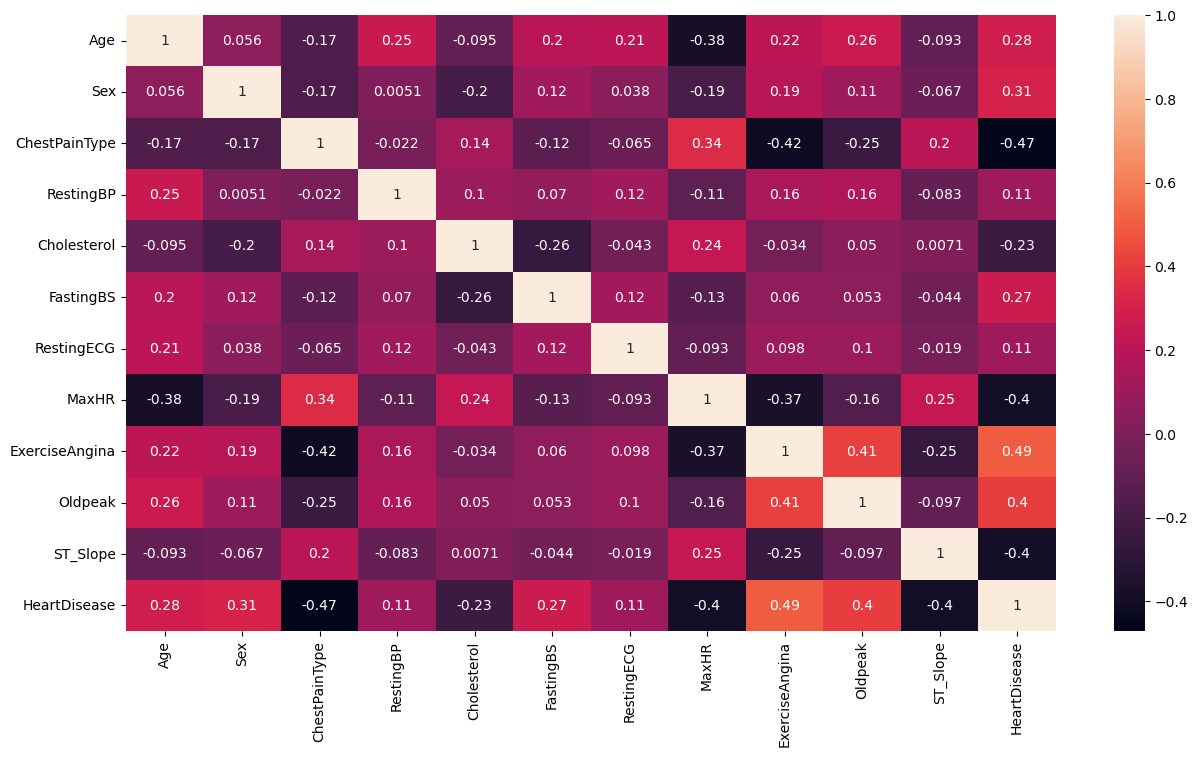

In [27]:
relations = df.corr()
plt.figure(figsize=(15,8))
sns.heatmap(data=relations, annot=True)

<Axes: xlabel='Sex'>

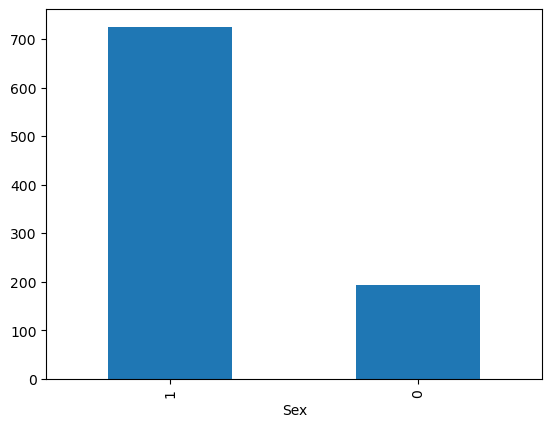

In [23]:
df["Sex"].value_counts().plot.bar()

<Axes: xlabel='ST_Slope'>

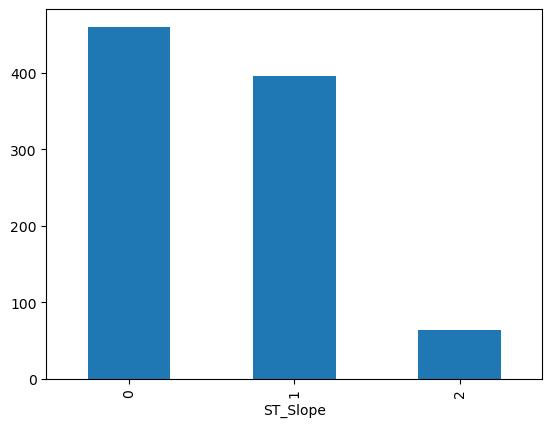

In [17]:
df["ST_Slope"].value_counts().plot.bar()

<Axes: xlabel='ChestPainType'>

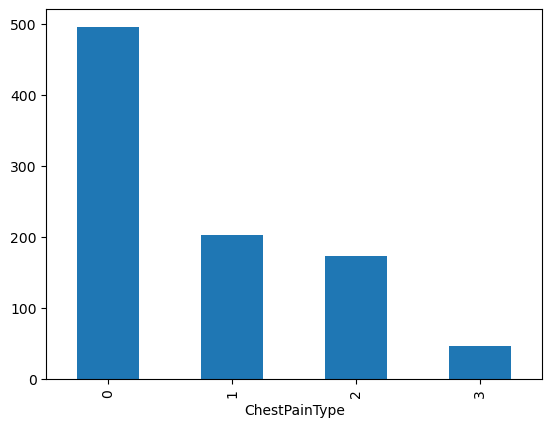

In [18]:
df["ChestPainType"].value_counts().plot.bar()

<Axes: xlabel='RestingECG'>

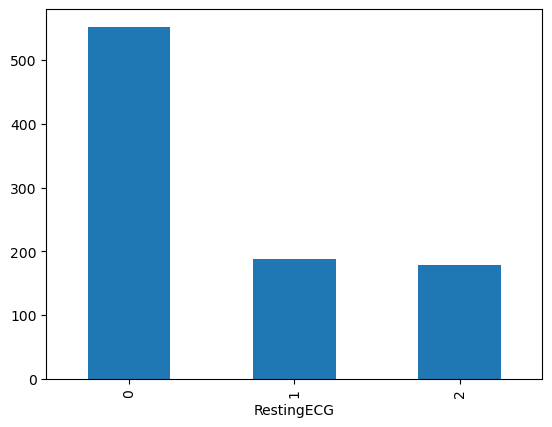

In [24]:
df["RestingECG"].value_counts().plot.bar()

/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_30333/1878150304.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_30333/1878150304.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_30333/1878150304.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_30333/1878150304.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_30333/1878150304.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_30333/1878150304.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_30333/18781

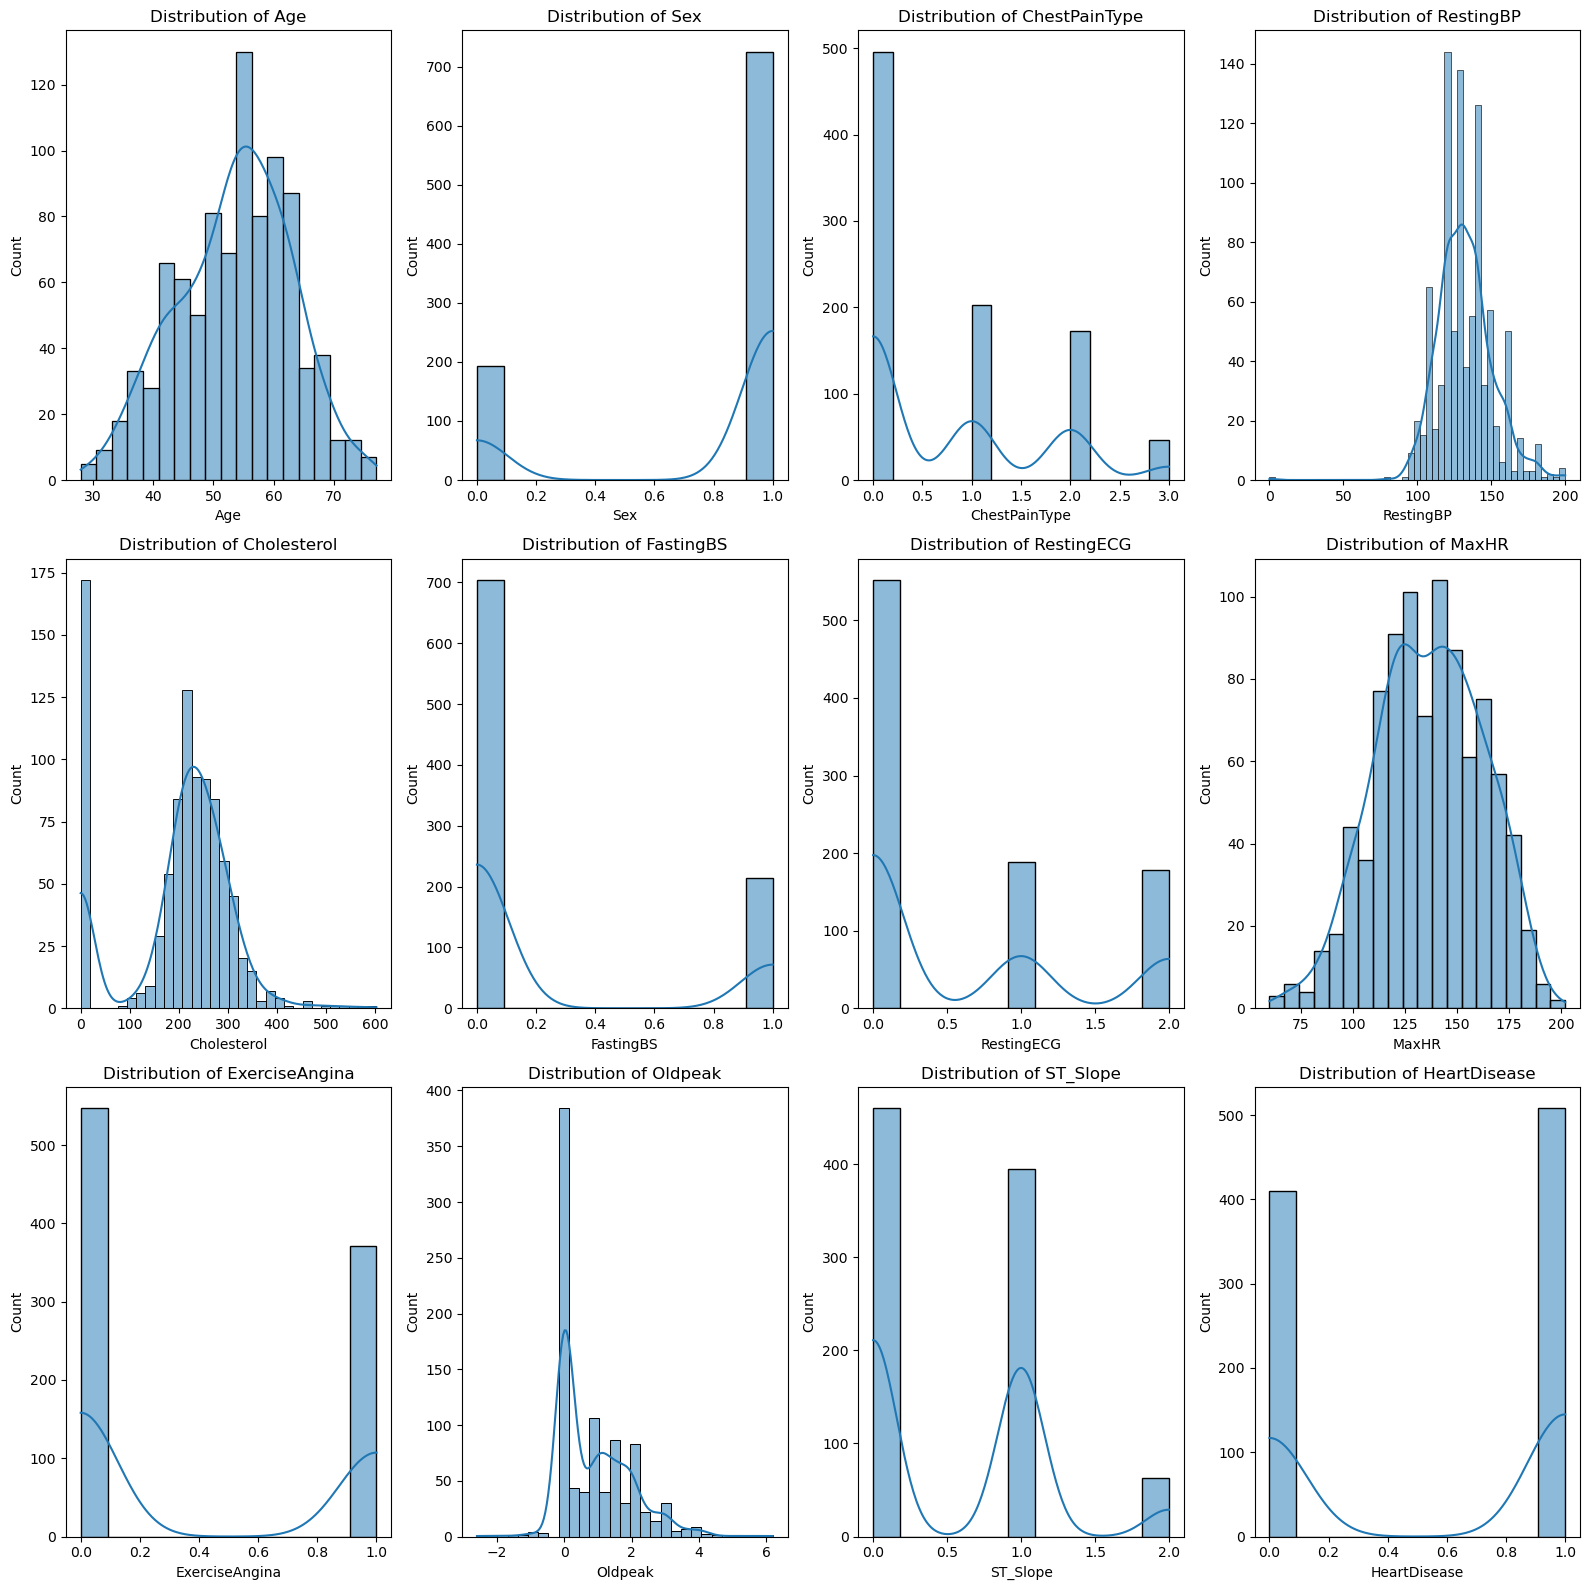

In [28]:
df_width= len(df.columns)
rows = (df_width +3)//4
plt.figure(figsize=(16,16))

for idx, col in enumerate(df.columns):
  plt.subplot(rows, 4, idx+1)
  sns.histplot(df[col], kde=True)
  plt.title(f"Distribution of {col}")
  plt.tight_layout()
  plt.plot()

## I am not a doctor but is it possible to have 0 cholesterol? (Apparently low cholesterol is a sign for numerous health problems so we cannot remove it from the data set)

/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_30333/3390829395.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_30333/3390829395.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_30333/3390829395.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_30333/3390829395.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_30333/3390829395.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_30333/3390829395.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_30333/33908

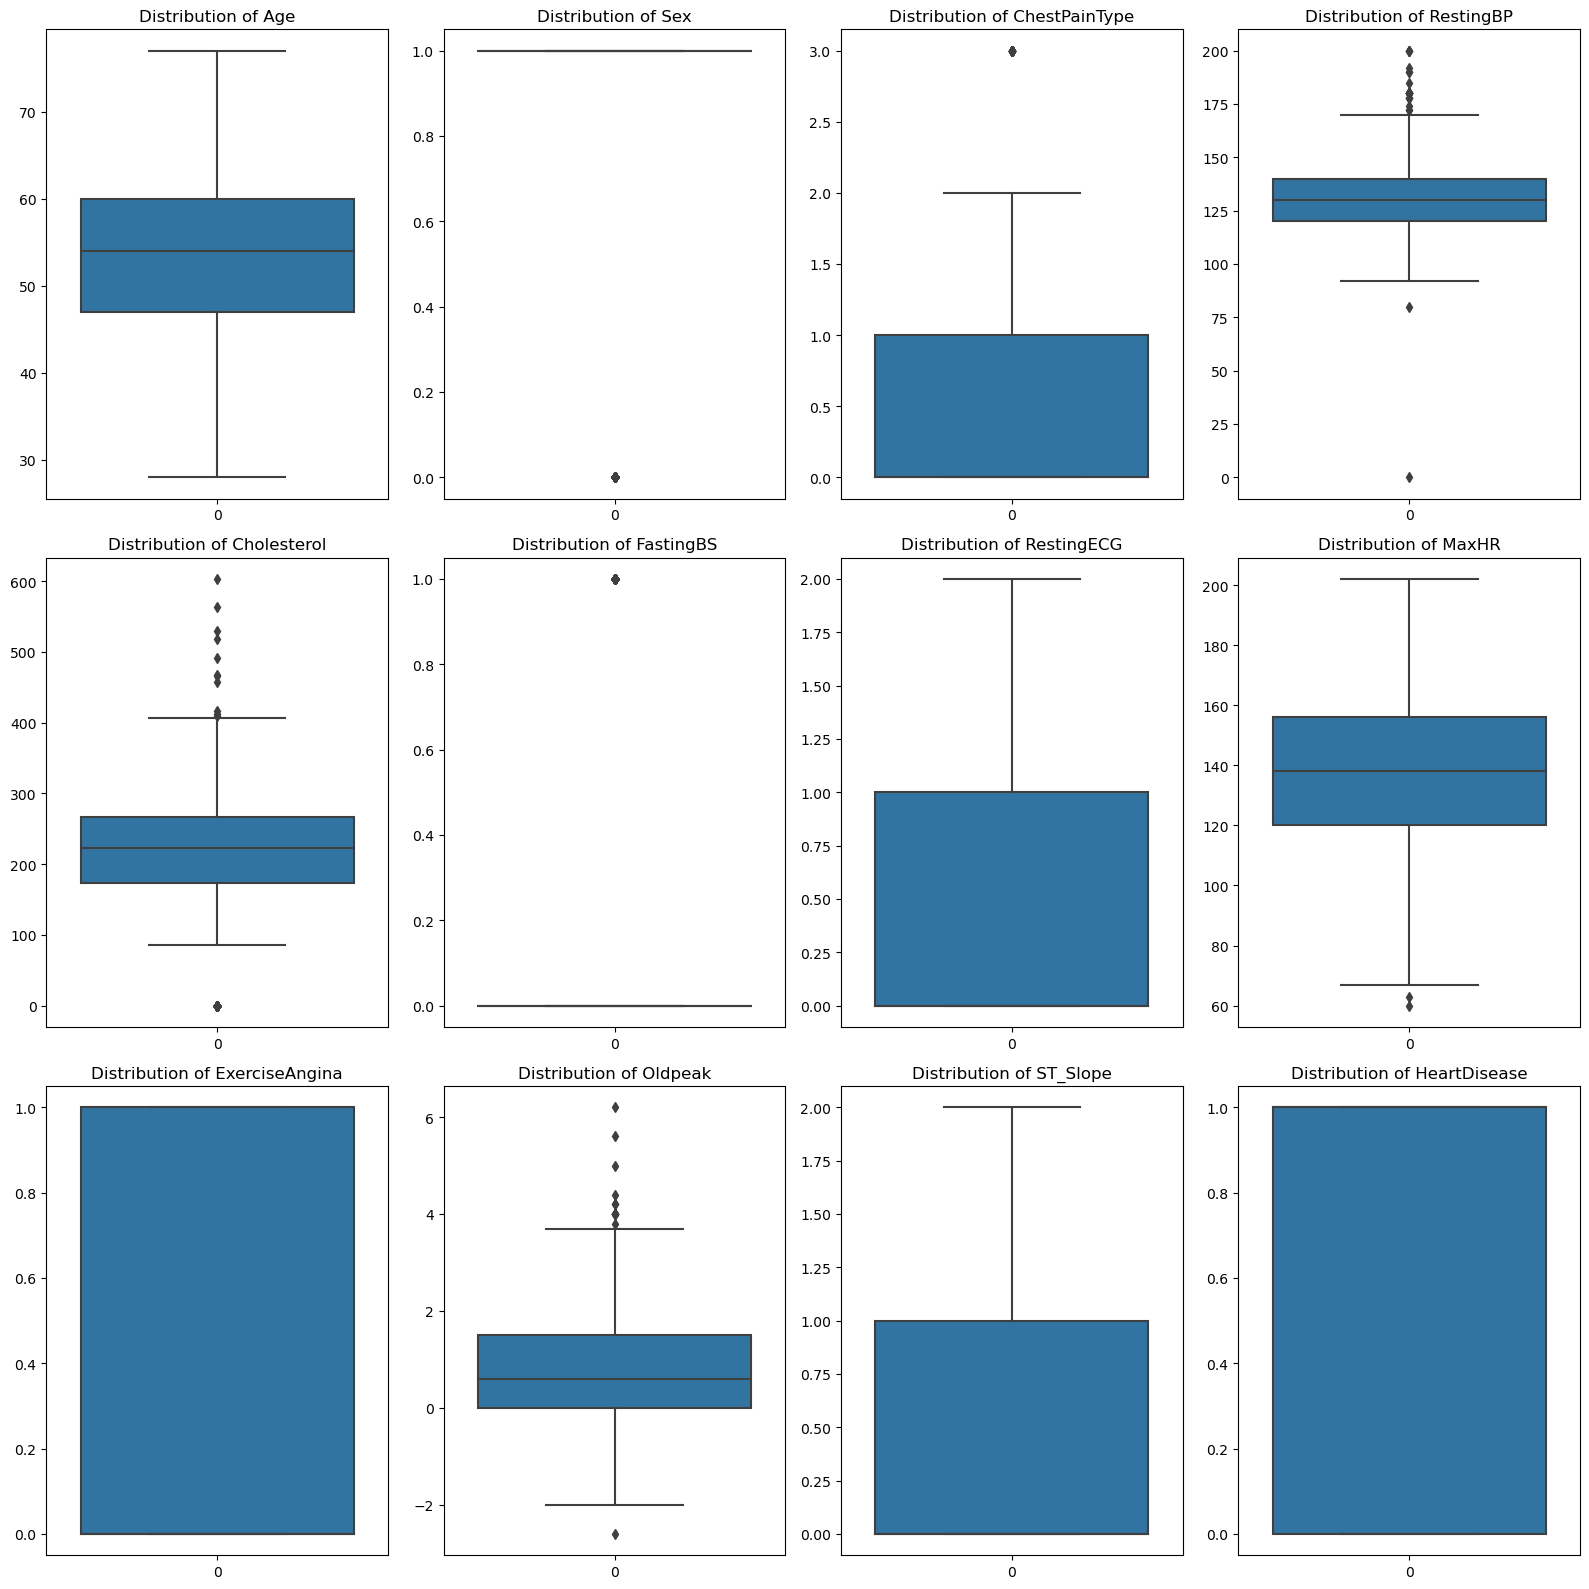

In [29]:
df_width= len(df.columns)
rows = (df_width +3)//4
plt.figure(figsize=(16,16))

for idx, col in enumerate(df.columns):
  plt.subplot(rows, 4, idx+1)
  sns.boxplot(df[col])
  plt.title(f"Distribution of {col}")
  plt.tight_layout()
  plt.plot()

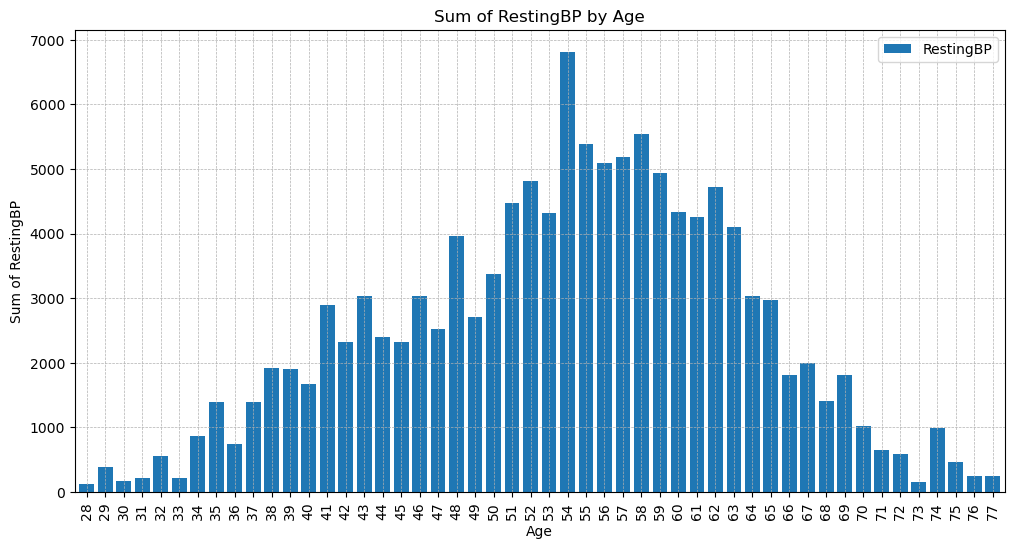

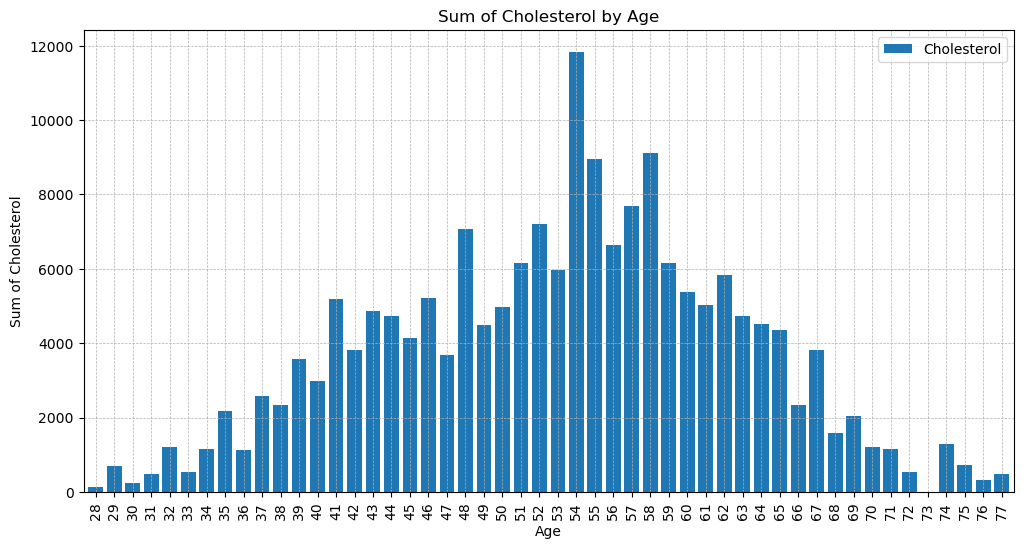

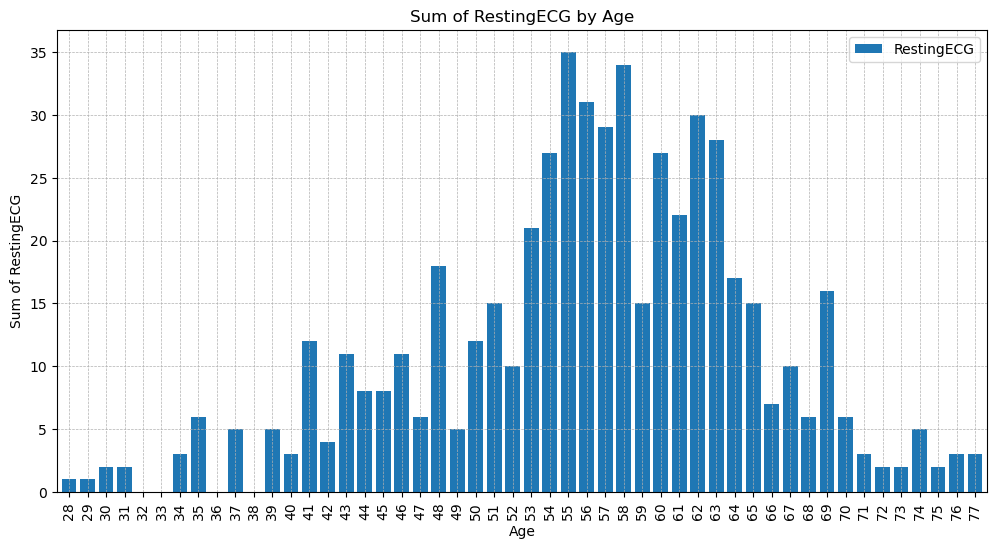

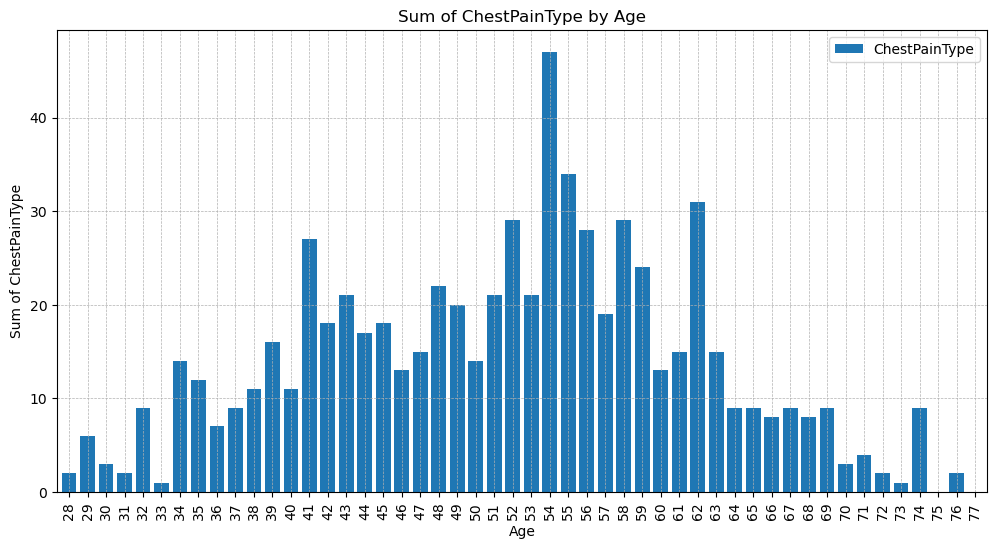

In [45]:

# Set a larger figure size and higher resolution
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

interested_columns = ["RestingBP", "Cholesterol", "RestingECG", "ChestPainType"]

for col in interested_columns:
    df_grouped = df.groupby("Age")[col].sum().reset_index()
    
    # Create the plot
    df_grouped.plot(kind="bar", x="Age", y=col, width=0.8) # Adjust bar width as needed
    
    # Set labels and title
    plt.xlabel("Age")
    plt.ylabel(f"Sum of {col}")
    plt.title(f"Sum of {col} by Age")
    
    # Add gridlines
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Show the plot
    plt.show()

# Model Evaluation

In [52]:
from sklearn.compose import ColumnTransformer
from sklearn.metrics import fbeta_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

def f2_measure(y_true, y_pred):
  return fbeta_score(y_true, y_pred, beta=2)

# evaluate a model
def evaluate_model(X, y, model):
  # define evaluation procedure
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  
  metric = make_scorer(f2_measure)
  # evaluate model
  scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
  return scores

last_ix = len(df.columns)-1
X, y = df.drop(df.columns[last_ix], axis=1), df[df.columns[last_ix]]
# summarize the loaded dataset
print(X.shape, y.shape, Counter(y))
# define the reference model
model = DummyClassifier(strategy='stratified')
# evaluate the model
scores = evaluate_model(X, y, model)
# summarize performance
print('Mean F2: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

(918, 11) (918,) Counter({1: 508, 0: 410})
Mean F2: 0.552 (0.049)


## Baseline Model Performance tell us we need an F2 score of atleast 0.55%. One thing to note here, is how we decide to measure how grave a type two error is. In this case, that would be telling a patient they don't have heart disease when in fact they do have heart disease. This is the scope through which I am guiding my analysis. Given that Heart Disease is one of the leading causes of death for adults in America


In [53]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
scaler = MinMaxScaler()
X_train_scaled, X_test_scaled = scaler.fit_transform(X_train), scaler.transform(X_test)
models = run_all_models(X_train_scaled, X_test_scaled, y_train, y_test)
models.sort_values(by="Accuracy", ascending=False)

2024-04-06 20:17:35.989834: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


6/6 [==============================] - 0s 517us/step - loss: 0.3330 - accuracy: 0.8750


,Model,Accuracy
9,Sequential,0.875000
3,RandomForestClassifier,0.869565
4,KNeighborsClassifier,0.864130
5,GradientBoostingClassifier,0.864130
1,SVC,0.858696
8,GPC,0.858696
7,LDA,0.847826
0,LogisticRegression,0.842391
6,GaussianNB,0.836957
2,DecisionTreeClassifier,0.815217


# Advanced Modeling

In [54]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer

def f2_measure(y_true, y_pred):
  return fbeta_score(y_true, y_pred, beta=2)

# evaluate a model
def evaluate_model(X, y, model):
  # define evaluation procedure
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  
  metric = make_scorer(f2_measure)
  # evaluate model
  scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
  return scores

# define models to test
def get_models():
  models, names = list(), list()
  # LDA
  models.append(LinearDiscriminantAnalysis()) 
  names.append('LDA')
  # RFC
  models.append(RandomForestClassifier())
  names.append('RFC')
  # GBC
  models.append(GradientBoostingClassifier())
  names.append('GBC')
  # KNN
  models.append(KNeighborsClassifier())
  names.append('KNN')
  # SVC
  models.append(SVC())
  names.append('SVC')
  # LR
  models.append(LogisticRegression())
  names.append('LR')
  #GPC
  models.append(GaussianProcessClassifier())
  names.append('GPC')
  #GNB
  models.append(GaussianNB())
  names.append('GNB')
  #DTC
  models.append(DecisionTreeClassifier())
  names.append('DTC')
  
  return models, names

llast_ix = len(df.columns)-1
X, y = df.drop(df.columns[last_ix], axis=1), df[df.columns[last_ix]]
models, names = get_models()
# evaluate each model
for i in range(len(models)):
  # Wrap the model in a pipeline with StandardScaler
  pipeline = Pipeline(steps=[('scaler', MinMaxScaler()), ("power_tranformer",PowerTransformer()), ('model', models[i])])
  # Evaluate the model
  scores = evaluate_model(X, y, pipeline)  # Replace X, y with your data
  # summarize and store
  print('>%s %.3f (%.3f)' % (names[i], np.mean(scores), np.std(scores)))

>LDA 0.864 (0.042)
>RFC 0.896 (0.033)
>GBC 0.892 (0.039)
>KNN 0.878 (0.036)
>SVC 0.906 (0.036)
>LR 0.869 (0.042)
>GPC 0.866 (0.040)
>GNB 0.877 (0.033)
>DTC 0.800 (0.057)


## After testing on multiple subsets of data, the models with the highest mean and lowest STD ratio will be picked to continue our modeling process

## Top Models to continue testing are: SVC, GBC and RFC but let us do some feature importance

# Feature Importance

#### Since we have numeric inputs into a binary categorical output such as heart-attack vs no heart attack. This is a job suitable for the ANOVA measure.

In [68]:
# compare different numbers of features selected using anova f-test
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.pipeline import Pipeline

def f2_measure(y_true, y_pred):
  return fbeta_score(y_true, y_pred, beta=2)
# define models to test
def get_models():
  models, names = list(), list()
  # RFC
  models.append(RandomForestClassifier())
  names.append('RFC')
  # GBC
  models.append(GradientBoostingClassifier())
  names.append('GBC')
  # KNN
  models.append(KNeighborsClassifier())
  names.append('KNN')
  # SVC
  models.append(SVC())
  names.append('SVC')
  # LR
  models.append(LogisticRegression())
  names.append('LR')
  # DTC
  models.append(DecisionTreeClassifier())
  names.append('DTC')
  # GNB
  models.append(GaussianNB())
  names.append('GNB')
  # GPC
  models.append(GaussianProcessClassifier())
  names.append('GPC')
  # LDA
  models.append(LinearDiscriminantAnalysis())
  names.append('LDA')
  
  return models, names
# evaluate a model
def evaluate_model(X, y, model):
  # define evaluation procedure
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  metric = make_scorer(f2_measure)
  # evaluate model
  scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
  return scores

last_ix = len(df.columns)-1
X, y = df.drop(df.columns[last_ix], axis=1), df[df.columns[last_ix]]
# define dataset
models,names = [], []
models, names = get_models()
num_features = [i+1 for i in range(X.shape[1])] # enumerate each number of features
# Model Performance:
model_performance = []
for k in num_features:
  # create pipeline
  model = models[i]
  fs = SelectKBest(score_func=f_classif, k=k)
  for i in range(len(models)):
    # Wrap the model in a pipeline with StandardScaler
    pipeline = Pipeline(steps=[('scaler', MinMaxScaler()),("power_tranformer", PowerTransformer()), ('anova',fs), ('model', models[i])])
    # Evaluate the model
    scores = evaluate_model(X, y, pipeline)
    # summarize and store
    print('>%s %.3f (%.3f) k=%d' % (names[i], np.mean(scores), np.std(scores), k))
    print("---------------------------------------------------------------")
    model_performance.append({
            "Model": models[i],
            "mean": np.mean(scores),
            "std":np.std(scores),
            "column":k
        })
model_performance = pd.DataFrame(model_performance)
model_performance.sort_values(by="mean", ascending=False)

>RFC 0.775 (0.056) k=1
---------------------------------------------------------------
>GBC 0.775 (0.056) k=1
---------------------------------------------------------------
>KNN 0.674 (0.270) k=1
---------------------------------------------------------------
>SVC 0.775 (0.056) k=1
---------------------------------------------------------------
>LR 0.775 (0.056) k=1
---------------------------------------------------------------
>DTC 0.775 (0.056) k=1
---------------------------------------------------------------
>GNB 0.775 (0.056) k=1
---------------------------------------------------------------
>GPC 0.775 (0.056) k=1
---------------------------------------------------------------
>LDA 0.775 (0.056) k=1
---------------------------------------------------------------
>RFC 0.826 (0.036) k=2
---------------------------------------------------------------
>GBC 0.824 (0.036) k=2
---------------------------------------------------------------
>KNN 0.676 (0.126) k=2
---------------------

,Model,mean,std,column
84,SVC(),0.906968,0.038487,10
93,SVC(),0.906928,0.036220,11
75,SVC(),0.901808,0.035170,9
90,RandomForestClassifier(),0.898450,0.039368,11
66,SVC(),0.898197,0.035031,8
...,...,...,...,...
1,GradientBoostingClassifier(),0.774790,0.056195,1
3,SVC(),0.774790,0.056195,1
0,RandomForestClassifier(),0.774790,0.056195,1
11,KNeighborsClassifier(),0.676460,0.125988,2


In [69]:
model_performance.sort_values(by="mean", ascending=False)[:50]

,Model,mean,std,column
84,SVC(),0.906968,0.038487,10
93,SVC(),0.906928,0.036220,11
75,SVC(),0.901808,0.035170,9
90,RandomForestClassifier(),0.898450,0.039368,11
66,SVC(),0.898197,0.035031,8
81,RandomForestClassifier(),0.898057,0.040930,10
73,GradientBoostingClassifier(),0.894505,0.038872,9
72,RandomForestClassifier(),0.893682,0.034942,9
82,GradientBoostingClassifier(),0.893231,0.044872,10
91,GradientBoostingClassifier(),0.891655,0.038757,11


#### As you can see, SVC, GBC, GNB, RFC and LR are the best performing models we have on numerous subsets of data, we see that the highest measure we get for kbest columns is between 8-10 depending on the algorithm. Lets run Tests without focusing on the best measure vs the best measure and see if we can reduce dimensionality.

Model: RFC, Accuracy: 0.856, F2 Score: 0.876


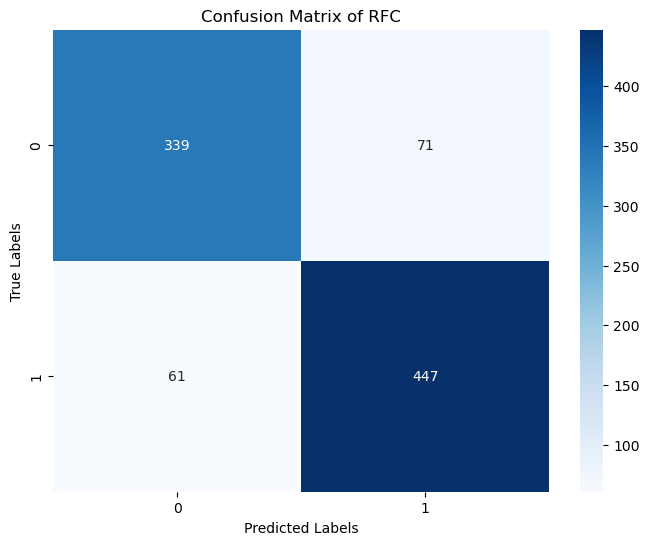

Model: GBC, Accuracy: 0.846, F2 Score: 0.859


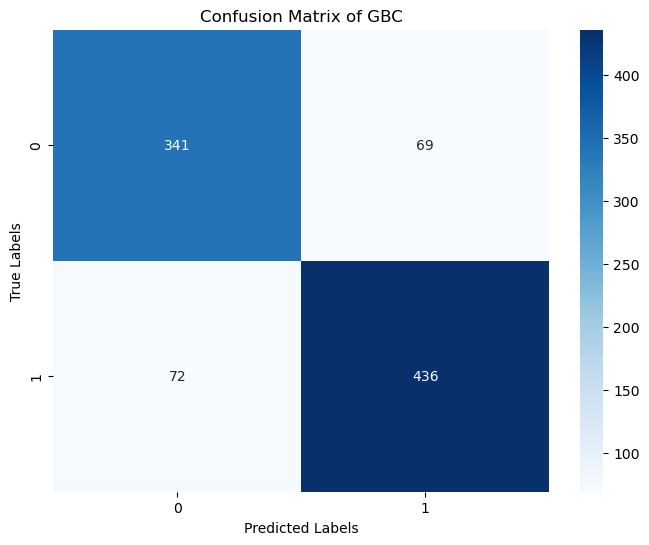

Model: SVC, Accuracy: 0.870, F2 Score: 0.897


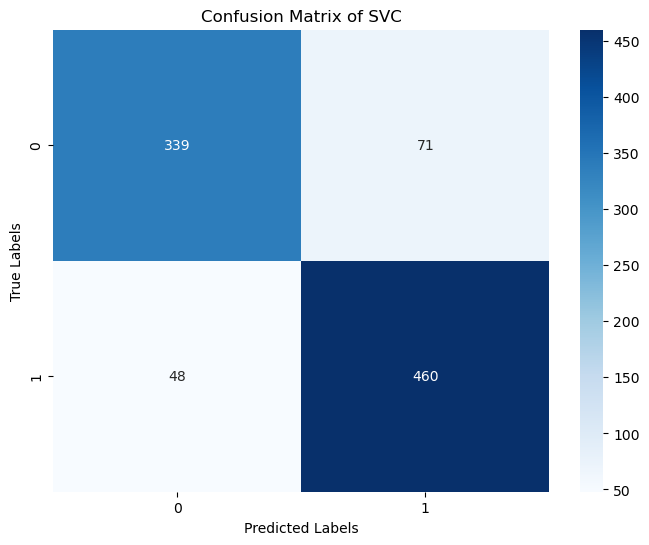

Model: LR, Accuracy: 0.834, F2 Score: 0.853


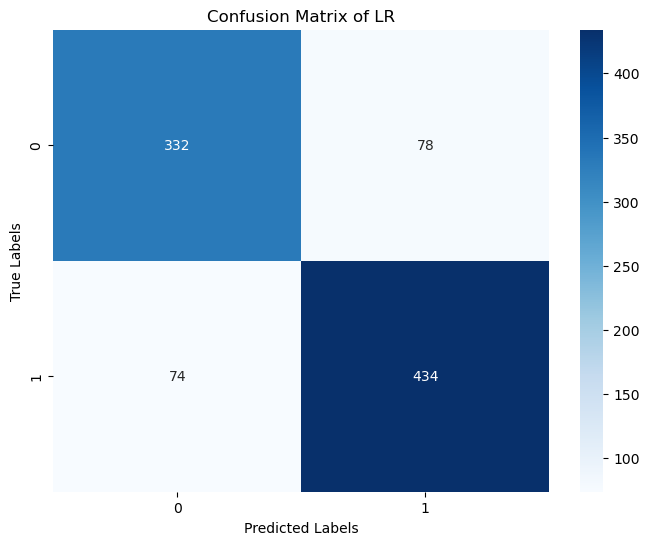

Model: GNB, Accuracy: 0.844, F2 Score: 0.869


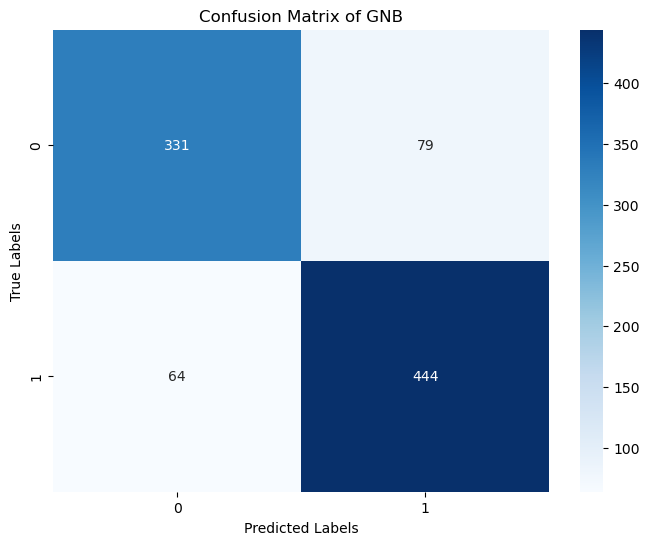

  Model  Accuracy  F2 Score
0   RFC  0.856209  0.876471
1   GBC  0.846405  0.859283
2   SVC  0.870370  0.897386
3    LR  0.834423  0.852987
4   GNB  0.844227  0.868885


In [81]:
from sklearn.calibration import cross_val_predict

def f2_measure(y_true, y_pred):
  return fbeta_score(y_true, y_pred, beta=2)
# define models to test
def get_models():
  models, names = list(), list()
  # RFC
  models.append(RandomForestClassifier())
  names.append('RFC')
  # GBC
  models.append(GradientBoostingClassifier())
  names.append('GBC')
  # SVC
  models.append(SVC())
  names.append('SVC')
  # LR
  models.append(LogisticRegression())
  names.append('LR')
  # GNB
  models.append(GaussianNB())
  names.append('GNB')
  return models, names

models, names = get_models()
model_performance = []
for i in range(len(models)):
    pipeline = Pipeline([
        ('scaler', MinMaxScaler()), 
        ('power_transformer', PowerTransformer()), 
        ('model', models[i])
    ])
    
    y_pred = cross_val_predict(pipeline, X, y, cv=10) 

    # Compute the desired metrics
    accuracy = accuracy_score(y, y_pred)
    f2 = f2_measure(y, y_pred)

    model_performance.append({
        "Model": names[i],
        "Accuracy": accuracy,
        "F2 Score": f2
    })

    print(f"Model: {names[i]}, Accuracy: {accuracy:.3f}, F2 Score: {f2:.3f}")
    
    # Generate the confusion matrix
    conf_mat = confusion_matrix(y, y_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix of {names[i]}')
    plt.show()

# Convert the model_performance to a DataFrame for easier analysis
performance_df = pd.DataFrame(model_performance)
print(performance_df)

# Applying Kbest columns and assessing if the model performance changes or improves

Model: RFC, Accuracy: 0.859, F2 Score: 0.881


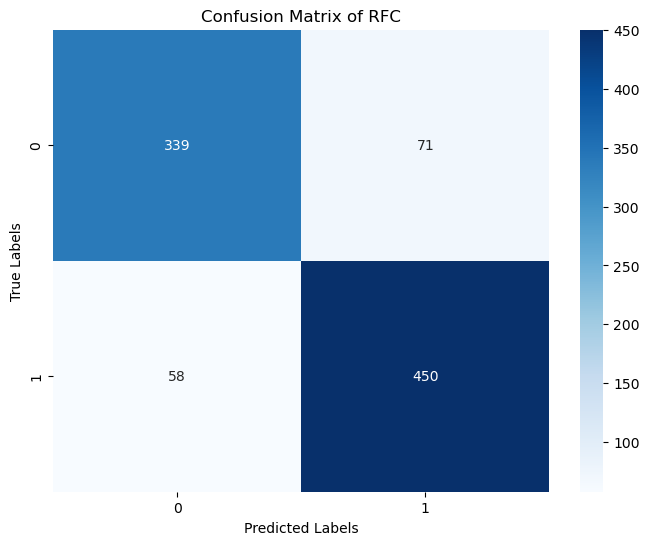

Model: GBC, Accuracy: 0.851, F2 Score: 0.867


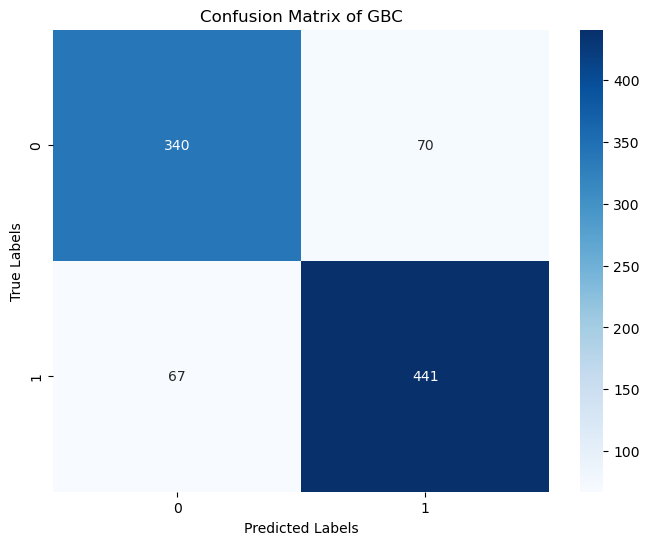

Model: SVC, Accuracy: 0.869, F2 Score: 0.896


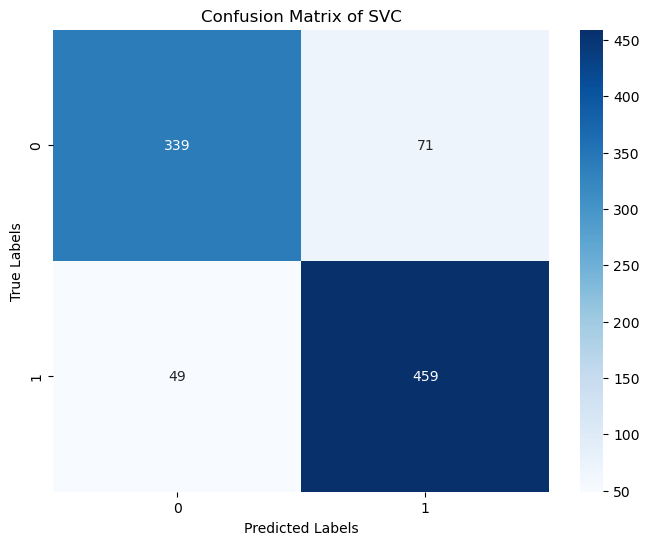

Model: LR, Accuracy: 0.831, F2 Score: 0.848


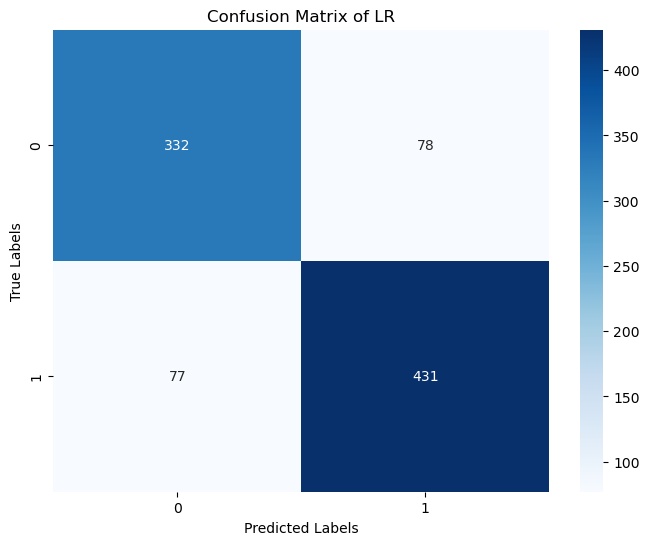

Model: GNB, Accuracy: 0.847, F2 Score: 0.872


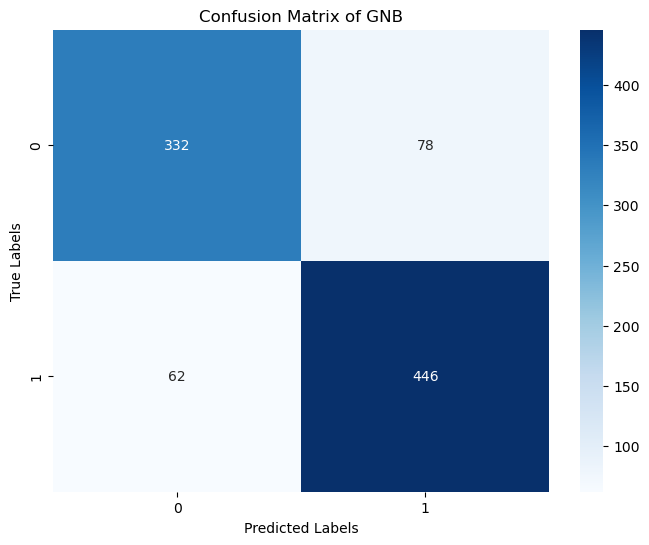

  Model  Accuracy  F2 Score
0   RFC  0.859477  0.881316
1   GBC  0.850763  0.867086
2   SVC  0.869281  0.895785
3    LR  0.831155  0.848091
4   GNB  0.847495  0.872457


In [82]:
from sklearn.calibration import cross_val_predict

def f2_measure(y_true, y_pred):
  return fbeta_score(y_true, y_pred, beta=2)
# define models to test
def get_models():
  models, names = list(), list()
  # RFC
  models.append(RandomForestClassifier())
  names.append('RFC')
  # GBC
  models.append(GradientBoostingClassifier())
  names.append('GBC')
  # SVC
  models.append(SVC())
  names.append('SVC')
  # LR
  models.append(LogisticRegression())
  names.append('LR')
  # GNB
  models.append(GaussianNB())
  names.append('GNB')
  return models, names

models, names = get_models()
model_performance = []
for i in range(len(models)):
    fs = SelectKBest(score_func=f_classif, k=10)
    pipeline = Pipeline([
        ('scaler', MinMaxScaler()), 
        ('power_transformer', PowerTransformer()), 
        ("anova",fs),
        ('model', models[i])
    ])
    
    y_pred = cross_val_predict(pipeline, X, y, cv=10) 

    # Compute the desired metrics
    accuracy = accuracy_score(y, y_pred)
    f2 = f2_measure(y, y_pred)

    model_performance.append({
        "Model": names[i],
        "Accuracy": accuracy,
        "F2 Score": f2
    })

    print(f"Model: {names[i]}, Accuracy: {accuracy:.3f}, F2 Score: {f2:.3f}")
    
    # Generate the confusion matrix
    conf_mat = confusion_matrix(y, y_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix of {names[i]}')
    plt.show()

# Convert the model_performance to a DataFrame for easier analysis
performance_df = pd.DataFrame(model_performance)
print(performance_df)

# Now lets do some hyperparameter tunning

Model: RFC, Accuracy: 0.947, F2 Score: 0.963, Best Params: {'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 10, 'model__n_estimators': 100}


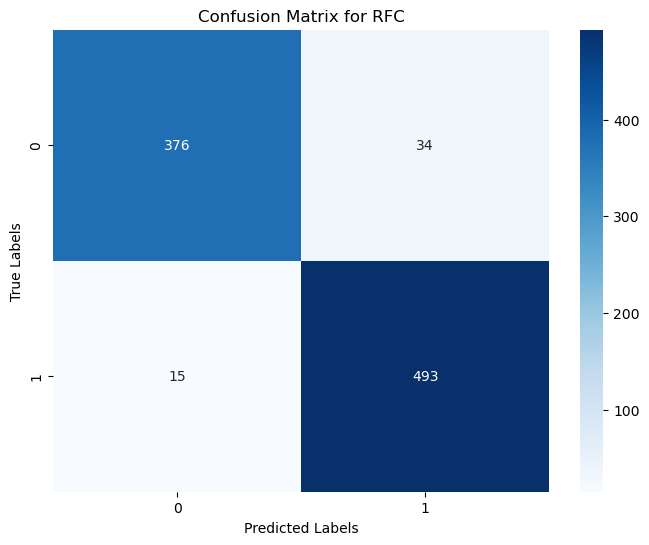

Model: GBC, Accuracy: 0.875, F2 Score: 0.920, Best Params: {'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__n_estimators': 100}


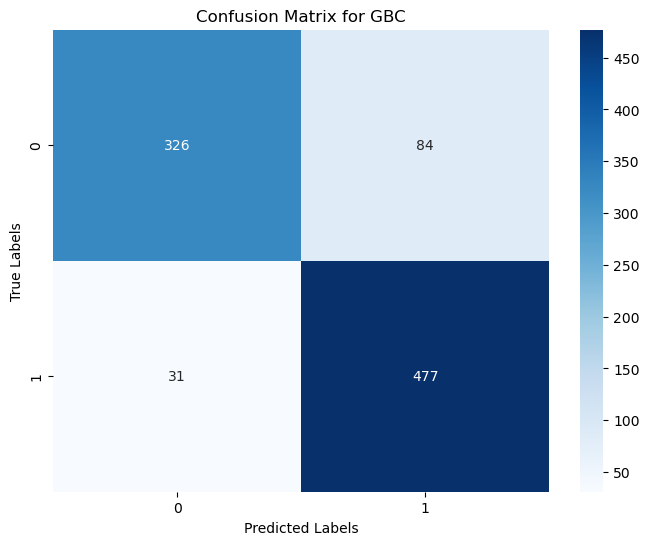

Model: SVC, Accuracy: 0.874, F2 Score: 0.912, Best Params: {'model__C': 0.1, 'model__gamma': 0.1, 'model__kernel': 'rbf'}


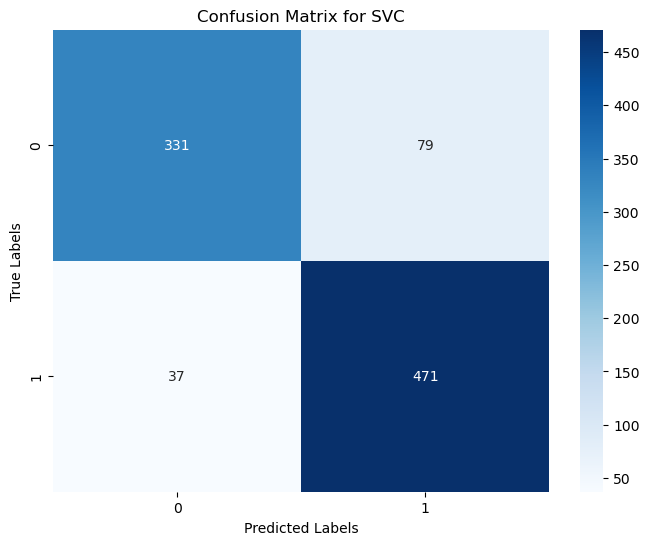

In [83]:
from sklearn.model_selection import GridSearchCV

def f2_measure(y_true, y_pred):
  return fbeta_score(y_true, y_pred, beta=2)

# define models to test
def get_models():
  models, names = list(), list()
  # RFC
  models.append(RandomForestClassifier())
  names.append('RFC')
  # GBC
  models.append(GradientBoostingClassifier())
  names.append('GBC')
  # SVC
  models.append(SVC())
  names.append('SVC')
  return models, names

models, names = [], []
models, names = get_models()
model_performance = []

params = [
    {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [None, 10, 20, 30],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4]
    },
    {
        'model__n_estimators': [100, 200, 300],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 5, 7]
    },
    {
        'model__C': [0.1, 1, 10],
        'model__gamma': [0.1, 1, 10],
        'model__kernel': ['linear', 'rbf', 'poly']
    },
    {
        'model__C': [0.1, 1, 10, 100],
        'model__solver': ['lbfgs', 'saga'],
        'model__max_iter': [100, 200, 300]
    },
]

for i in range(len(models)):
    pipeline = Pipeline([
        ('scaler', StandardScaler()), 
        ("power_transformer", PowerTransformer()),
        ("anova", SelectKBest(score_func=f_classif, k=10)),
        ('model', models[i])
    ])
    
    f2_scorer = make_scorer(f2_measure)
    # Set up the grid search
    grid_search = GridSearchCV(estimator=pipeline, param_grid=params[i], cv=10, scoring=f2_scorer, n_jobs=-1)
    grid_search.fit(X, y)
    
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X)
    
    # Compute the desired metrics using the best model found by grid search
    accuracy = accuracy_score(y, y_pred)
    f2 = f2_measure(y, y_pred)

    model_performance.append({
        "Model": names[i],
        "Accuracy": accuracy,
        "F2 Score": f2,
        "Best Params": grid_search.best_params_
    })

    print(f"Model: {names[i]}, Accuracy: {accuracy:.3f}, F2 Score: {f2:.3f}, Best Params: {grid_search.best_params_}")
    # Generate the confusion matrix
    conf_mat = confusion_matrix(y, y_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix for {names[i]}')
    plt.show()

# Conclusion

## Wow, model parameter tunning gave us a 96% F2 Score, and increased model performance for all models. Lesson learned, never stop hyper tunining. Thank you for the dataset, I had a lot of fun.